In [1]:
!pip install tensorflow imageio tensorflow-docs

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 182.7/182.7 kB 4.8 MB/s eta 0:00:00


In [20]:
import tensorflow as tf
import glob
import imageio
import numpy as np
import os
import PIL
from tensorflow.keras import layers
from tensorflow.keras.layers import LeakyReLU
import time
from IPython import display
import matplotlib.pyplot as plt

Loading MNIST handwritten digit

In [3]:
(train_images,train_labels), (_,_) = tf.keras.datasets.mnist.load_data()    #We dont working on classification so dont need of testing data

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [4]:
train_images = train_images.reshape(train_images.shape[0],28,28,1).astype('float32')
train_images = (train_images - 127.5) / 127.5

1. Generator Output Activation is tanh
The final layer of most GAN generators uses the tanh activation function, which outputs values from -1 to 1.

If your real images (used to train the discriminator) are in a different scale (like [0, 1]), then:

The discriminator will easily tell real vs. fake just by value range, which makes training unstable.

The gradient flow to the generator becomes weak or skewed.

In [5]:
BEFFER_SIZE = 60000
BATCH_SIZE = 256

In [34]:
train_dataset = tf.data.Dataset.from_tensor_slices(train_images).shuffle(BEFFER_SIZE).batch(BATCH_SIZE)

In [35]:
noise = np.random.normal(size = (1,100))
noise

array([[-0.33347376,  0.2899341 ,  0.30875401, -0.90858632,  1.09874163,
         1.51980796, -0.82832797, -0.16200763, -1.08972936, -0.87010782,
         0.11916428, -0.09519521, -1.29355838, -1.23886988,  1.03329238,
        -1.3083795 ,  1.34824784,  0.19957515,  0.72229908,  0.11856207,
         1.07706347, -0.49058945, -0.9847936 ,  0.85468182, -0.83536942,
        -1.23133425, -0.11075046,  1.93370858,  0.43776664, -1.01767066,
        -0.63158711, -0.49495201, -0.83083129,  1.31125756,  0.6102159 ,
         0.73073721, -1.94583012, -0.07393444, -0.96416568, -0.61142216,
         1.65235095,  0.61486878, -0.93873974, -0.82259306, -0.06852462,
        -1.53451374,  0.51358277, -0.55864291, -0.93990667,  0.36698644,
         0.91984333,  1.15939508,  1.00175044, -1.33740865, -0.30979299,
         0.46679105,  0.15002391,  1.4924622 , -2.56046627, -0.21734219,
         0.34392871,  0.61146851,  0.3658938 ,  0.04582284, -0.59410146,
        -1.26230524, -0.33581135,  0.66467108,  1.2

Generator

In [36]:
def make_generator():
  model = tf.keras.Sequential()
  model.add(layers.Dense(7*7*256, use_bias = False , input_shape = (100,)))
  model.add(layers.BatchNormalization())
  model.add(layers.LeakyReLU())

  model.add(layers.Reshape((7,7,256)))
  assert model.output_shape == (None,7,7,256)

  model.add(layers.Conv2DTranspose(128,(5,5), strides = (1,1), padding = 'same', use_bias = False))
  assert model.output_shape == (None,7,7,128)
  model.add(layers.BatchNormalization())
  model.add(layers.LeakyReLU())

  model.add(layers.Conv2DTranspose(64,(5,5), strides = (2,2), padding = 'same', use_bias = False))
  assert model.output_shape == (None,14,14,64)
  model.add(layers.BatchNormalization())
  model.add(layers.LeakyReLU())

  model.add(layers.Conv2DTranspose(1,(5,5) , strides = (2,2) , padding = 'same' , use_bias = False , activation = 'tanh'))
  assert model.output_shape == (None,28,28,1)

  return model

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


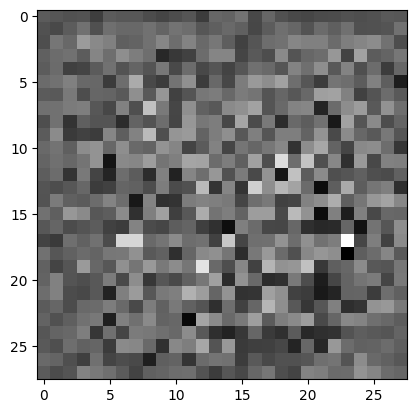

In [37]:
generator = make_generator()

noise = np.random.normal(size = (1,100))
generated_image = generator(noise,training = False)

plt.imshow(generated_image[0,:,:,0], cmap = 'gray')

Discriminator

In [38]:
def Discriminator():
  model = tf.keras.Sequential()
  model.add(layers.Conv2D(64,(5,5), strides = (2,2), padding = 'same', input_shape = [28,28,1]))
  model.add(layers.LeakyReLU())
  model.add(layers.Dropout(0.3))

  model.add(layers.Conv2D(64,(5,5), strides = (2,2), padding = 'same'))
  model.add(layers.LeakyReLU())
  model.add(layers.Dropout(0.3))

  model.add(layers.Flatten())
  model.add(layers.Dense(1))

  return model


In [39]:
discriminator = Discriminator()
decision = discriminator(generated_image)
print(decision)   #logists


tf.Tensor([[-0.00335682]], shape=(1, 1), dtype=float32)


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Loss and Optimizer

In [40]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits = True)


Discriminator Loss

In [41]:
def Discriminator_loss(real_output, fake_output):
  fake_loss = cross_entropy(tf.zeros_like(fake_output) , fake_output)
  real_loss = cross_entropy(tf.ones_like(real_output),real_output)
  total_loss = fake_loss + real_loss
  return total_loss

### 🔍 What’s Happening in Discriminator Loss

- `real_output`: Discriminator’s prediction on **real images** (should be close to **1**)
- `fake_output`: Discriminator’s prediction on **fake images** generated by the Generator (should be close to **0**)

### ⚙️ Internally:

- `cross_entropy(tf.ones_like(real_output), real_output)`  
  → Measures how well the Discriminator recognizes **real images as real**.

- `cross_entropy(tf.zeros_like(fake_output), fake_output)`  
  → Measures how well the Discriminator recognizes **fake images as fake**.

### 🧠 So:

- If the Discriminator is doing a **good job**, both losses will be **low**.
- If the Discriminator gets **fooled by fake images**, or **misclassifies real ones**, then the loss will **increase**.


Generator Loss

In [42]:
def Generator_loss(fake_output):
  return cross_entropy(tf.ones_like(fake_output),fake_output)

Optimizer

In [43]:
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

saving checkpoints

In [44]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

In [45]:
EPOCHS = 100
noise_dim = 100
num_examples_to_generate = 16

# You will reuse this seed overtime (so it's easier)
# to visualize progress in the animated GIF)
seed = tf.random.normal([num_examples_to_generate, noise_dim])

The training loop begins with generator receiving a random seed as input. That seed is used to produce an image. The discriminator is then used to classify real images (drawn from the training set) and fakes images (produced by the generator). The loss is calculated for each of these models, and the gradients are used to update the generator and discriminator.

In [46]:
# Notice the use of `tf.function`
# This annotation causes the function to be "compiled".
@tf.function

def train_step(images):
  noise = tf.random.normal([BATCH_SIZE,noise_dim])

  with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
    generated_images = generator(noise,training = True)

    real_output = discriminator(images,training = True)
    fake_output = discriminator(generated_images,training = True)

    gen_loss = Generator_loss(fake_output)
    disc_loss = Discriminator_loss(real_output,fake_output)

  gradient_of_generator = gen_tape.gradient = gen_tape.gradient(gen_loss, generator.trainable_variables)
  gradient_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

  generator_optimizer.apply_gradients(zip(gradient_of_generator,generator.trainable_variables))
  discriminator_optimizer.apply_gradients(zip(gradient_of_discriminator,discriminator.trainable_variables))

In [47]:
def train(dataset, epochs):
  for epoch in range(epochs):
    start = time.time()

    for image_batch in dataset:
      train_step(image_batch)

    # Produce images for the GIF as you go
    display.clear_output(wait=True)
    generate_and_save_images(generator,
                             epoch + 1,
                             seed)

    # Save the model every 15 epochs
    if (epoch + 1) % 15 == 0:
      checkpoint.save(file_prefix = checkpoint_prefix)

    print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))

  # Generate after the final epoch
  display.clear_output(wait=True)
  generate_and_save_images(generator,
                           epochs,
                           seed)

Generate and save image

In [48]:
def generate_and_save_images(model, epoch, test_input):
  # Notice `training` is set to False.
  # This is so all layers run in inference mode (batchnorm).
  predictions = model(test_input, training=False)

  fig = plt.figure(figsize=(4, 4))

  for i in range(predictions.shape[0]):
      plt.subplot(4, 4, i+1)
      plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
      plt.axis('off')

  plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
  plt.show()

Training the model

Call the train() method defined above to train the generator and discriminator simultaneously. Note, training GANs can be tricky. It's important that the generator and discriminator do not overpower each other (e.g., that they train at a similar rate).

At the beginning of the training, the generated images look like random noise. As training progresses, the generated digits will look increasingly real. After about 50 epochs, they resemble MNIST digits.



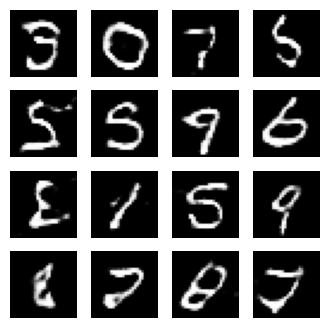

In [49]:
train(train_dataset, EPOCHS)

In [50]:
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

In [51]:
def display_image(epoch_no):
  return PIL.Image.open('image_at_epoch_{:04d}.png'.format(epoch_no))

In [52]:
anim_file = 'dcgan.gif'

with imageio.get_writer(anim_file, mode='I') as writer:
  filenames = glob.glob('image*.png')
  filenames = sorted(filenames)
  for filename in filenames:
    image = imageio.imread(filename)
    writer.append_data(image)
  image = imageio.imread(filename)
  writer.append_data(image)


<ipython-input-52-3580791786>:7: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(filename)
<ipython-input-52-3580791786>:9: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(filename)



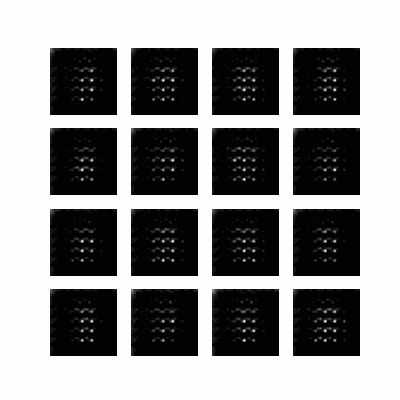

In [53]:
import tensorflow_docs.vis.embed as embed
embed.embed_file(anim_file)